In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision.transforms as T
import glob
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from collections import Counter
import seaborn as sns
import pandas as pd
import random

In [ ]:

class OxfordPetsDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform
        self.mask_transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)
        mask = self.mask_transform(mask)

        return img, mask, label


In [ ]:

image_dir = './images'
mask_dir = './annotations/trimaps/'

image_paths = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))

all_labels = [os.path.basename(p).split('_')[0].lower() for p in image_paths]



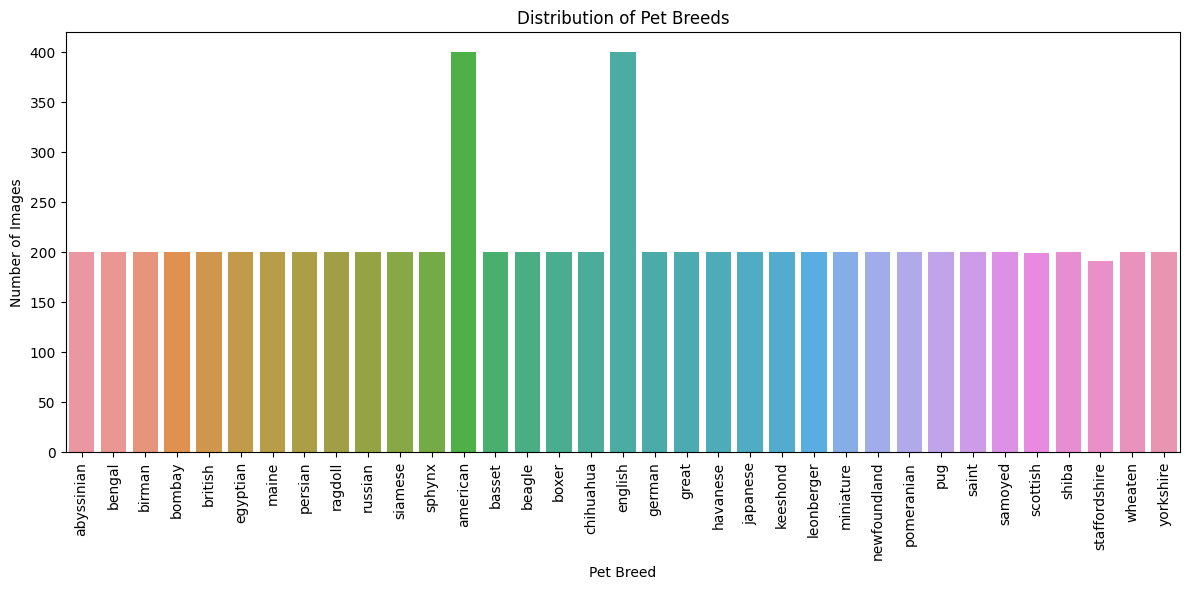

In [ ]:

label_counts = Counter(all_labels)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.xticks(rotation=90)
plt.title("Distribution of Pet Breeds")
plt.xlabel("Pet Breed")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

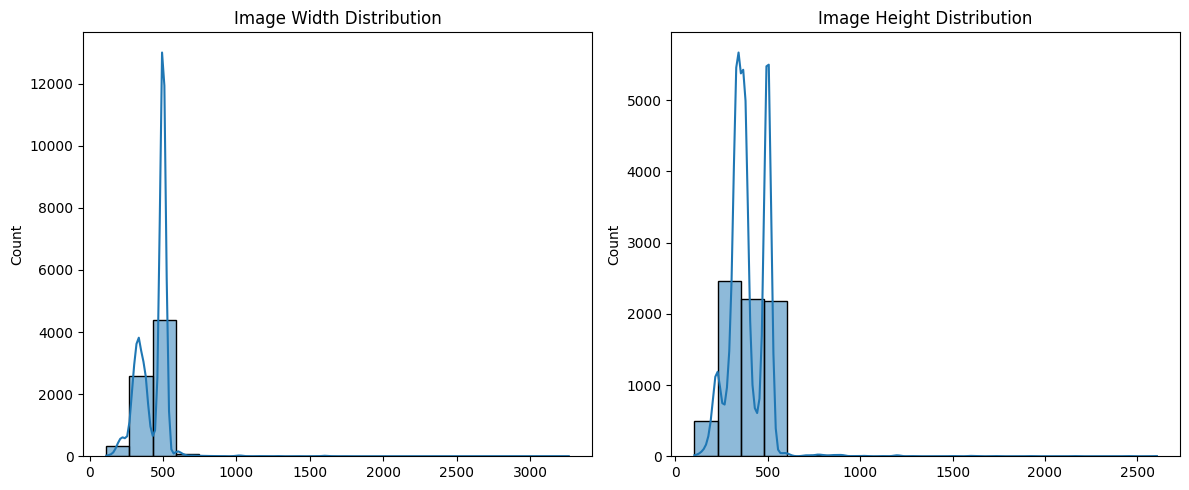

In [ ]:

heights, widths = [], []

for img_path in image_paths:
    img = Image.open(img_path)
    widths.append(img.width)
    heights.append(img.height)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(widths, bins=20, kde=True)
plt.title("Image Width Distribution")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=20, kde=True)
plt.title("Image Height Distribution")

plt.tight_layout()
plt.show()


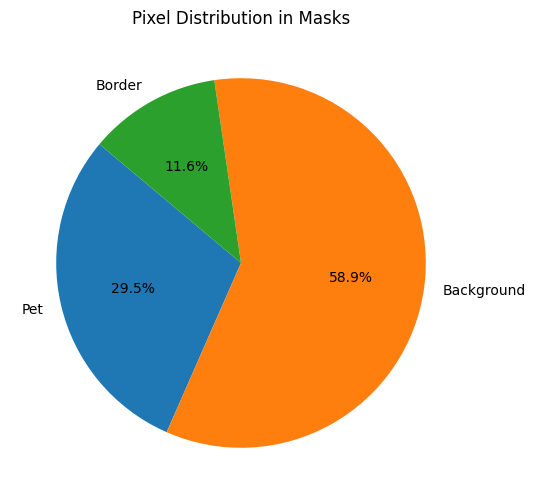

In [ ]:
mask_paths = [p.replace("images", "annotations/trimaps").replace(".jpg", ".png") for p in image_paths]
mask_class_counts = {1: 0, 2: 0, 3: 0}

for mask_path in mask_paths:
    mask = np.array(Image.open(mask_path))
    for val in [1, 2, 3]:
        mask_class_counts[val] += np.sum(mask == val)


plt.figure(figsize=(6, 6))
plt.pie(mask_class_counts.values(), labels=['Pet', 'Background', 'Border'], autopct='%1.1f%%', startangle=140)
plt.title("Pixel Distribution in Masks")
plt.show()


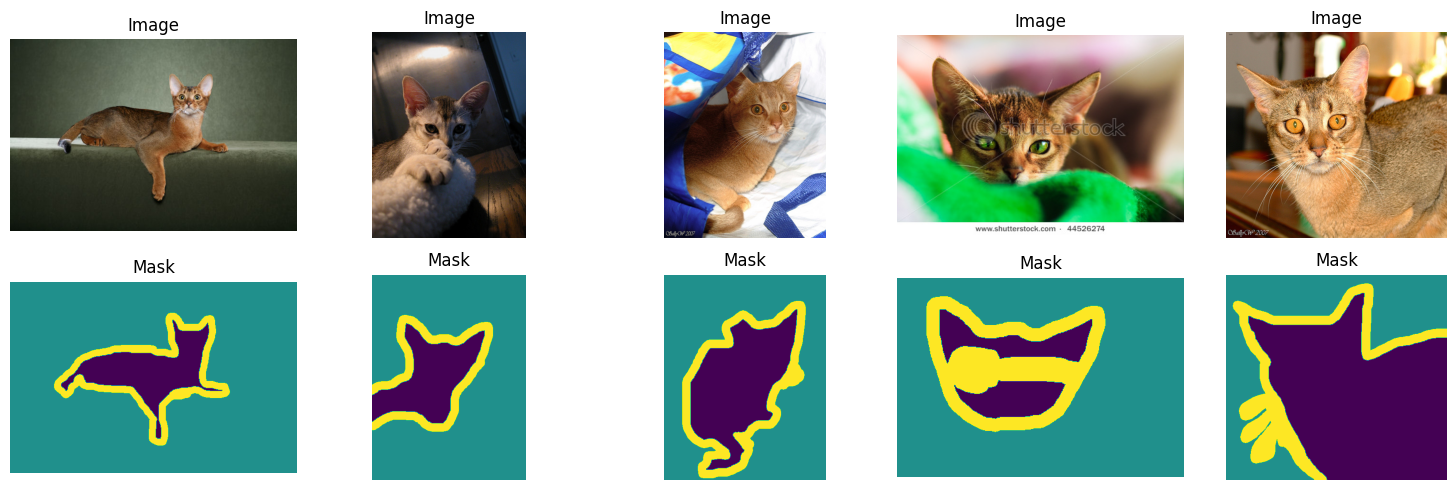

In [ ]:

def show_samples(image_paths, mask_paths, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        img = Image.open(image_paths[i])
        mask = Image.open(mask_paths[i])

        plt.subplot(2, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Image")

        plt.subplot(2, n, i + 1 + n)
        plt.imshow(mask)
        plt.axis('off')
        plt.title("Mask")

    plt.tight_layout()
    plt.show()

show_samples(image_paths, mask_paths, n=5)

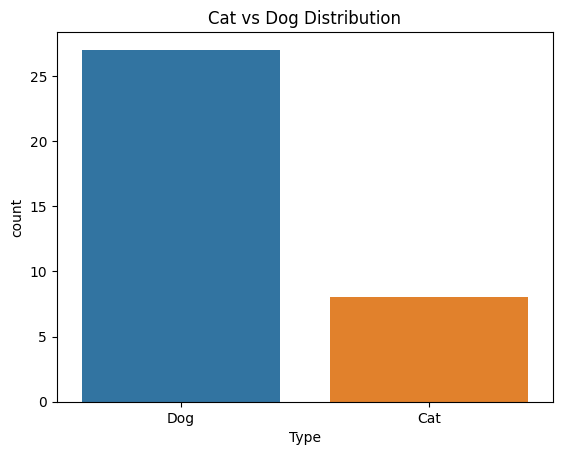

In [ ]:
breed_counts = Counter(all_labels)
df_breeds = pd.DataFrame(breed_counts.items(), columns=['Breed', 'Count']).sort_values(by='Count', ascending=False)
cat_breeds = [
    'abyssinian', 'bengal', 'birman', 'bombay', 'british_shorthair',
    'egyptian_mau', 'maine_coon', 'persian', 'ragdoll', 'russian_blue',
    'siamese', 'sphynx'
]


df_breeds['Type'] = df_breeds['Breed'].apply(lambda x: 'Cat' if x in cat_breeds else 'Dog')




sns.countplot(x='Type', data=df_breeds)
plt.title("Cat vs Dog Distribution")
plt.show()


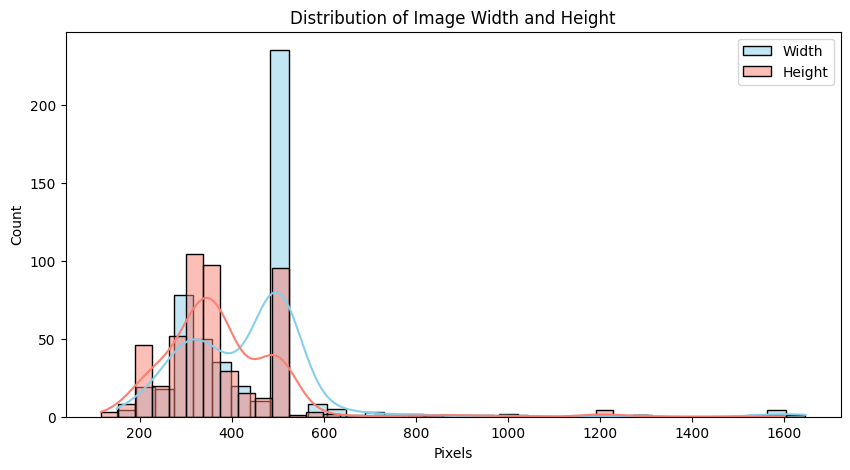

In [ ]:

widths, heights = [], []
for path in image_paths[:500]:
    img = Image.open(path)
    widths.append(img.width)
    heights.append(img.height)

plt.figure(figsize=(10, 5))
sns.histplot(widths, color='skyblue', label='Width', kde=True)
sns.histplot(heights, color='salmon', label='Height', kde=True)
plt.legend()
plt.title("Distribution of Image Width and Height")
plt.xlabel("Pixels")
plt.show()


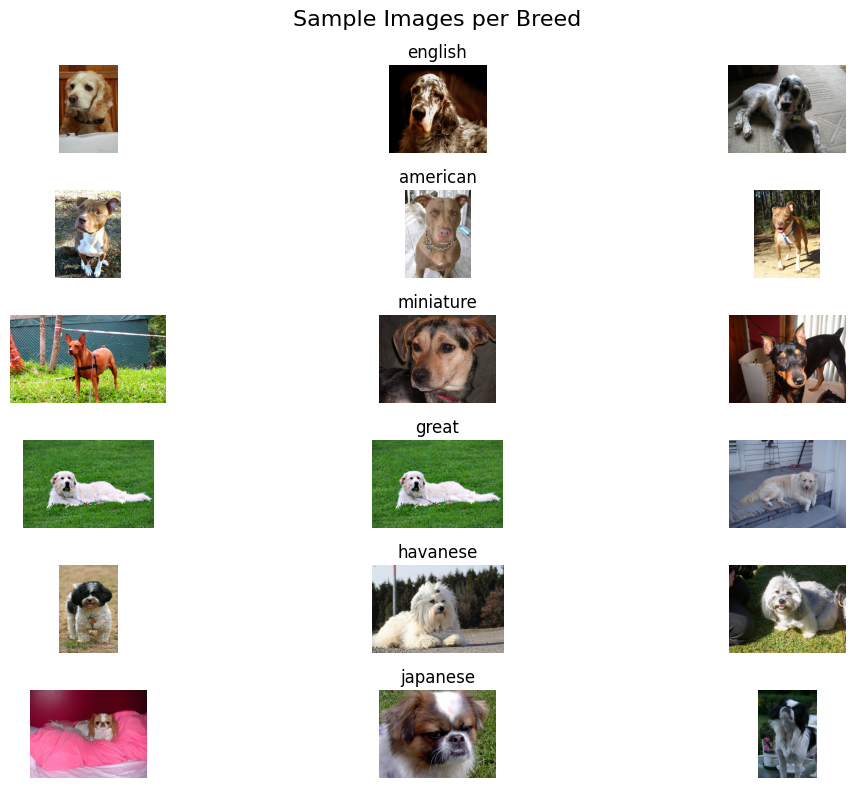

In [ ]:

unique_breeds = df_breeds['Breed'].head(6).tolist()
plt.figure(figsize=(12, 8))

for i, breed in enumerate(unique_breeds):
    breed_imgs = [p for p in image_paths if breed in p]
    for j in range(3):
        img = Image.open(random.choice(breed_imgs))
        plt.subplot(len(unique_breeds), 3, i * 3 + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if j == 1:
            plt.title(breed)

plt.suptitle("Sample Images per Breed", fontsize=16)
plt.tight_layout()
plt.show()


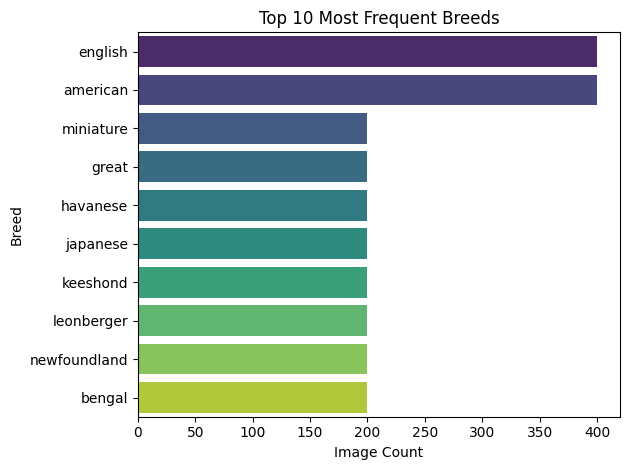

In [ ]:
top_breeds = df_breeds.head(10)
sns.barplot(y='Breed', x='Count', data=top_breeds, palette='viridis')
plt.title("Top 10 Most Frequent Breeds")
plt.xlabel("Image Count")
plt.ylabel("Breed")
plt.tight_layout()
plt.show()


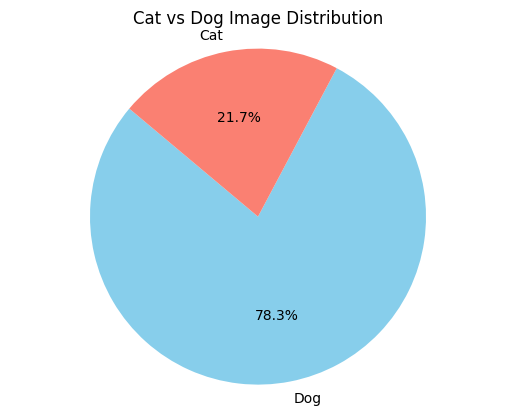

In [ ]:
df_images = pd.DataFrame({'Breed': all_labels})
df_images['Type'] = df_images['Breed'].apply(lambda x: 'Cat' if x in cat_breeds else 'Dog')
image_counts = df_images['Type'].value_counts()

plt.pie(image_counts, labels=image_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon'])
plt.axis('equal')
plt.title("Cat vs Dog Image Distribution")
plt.show()

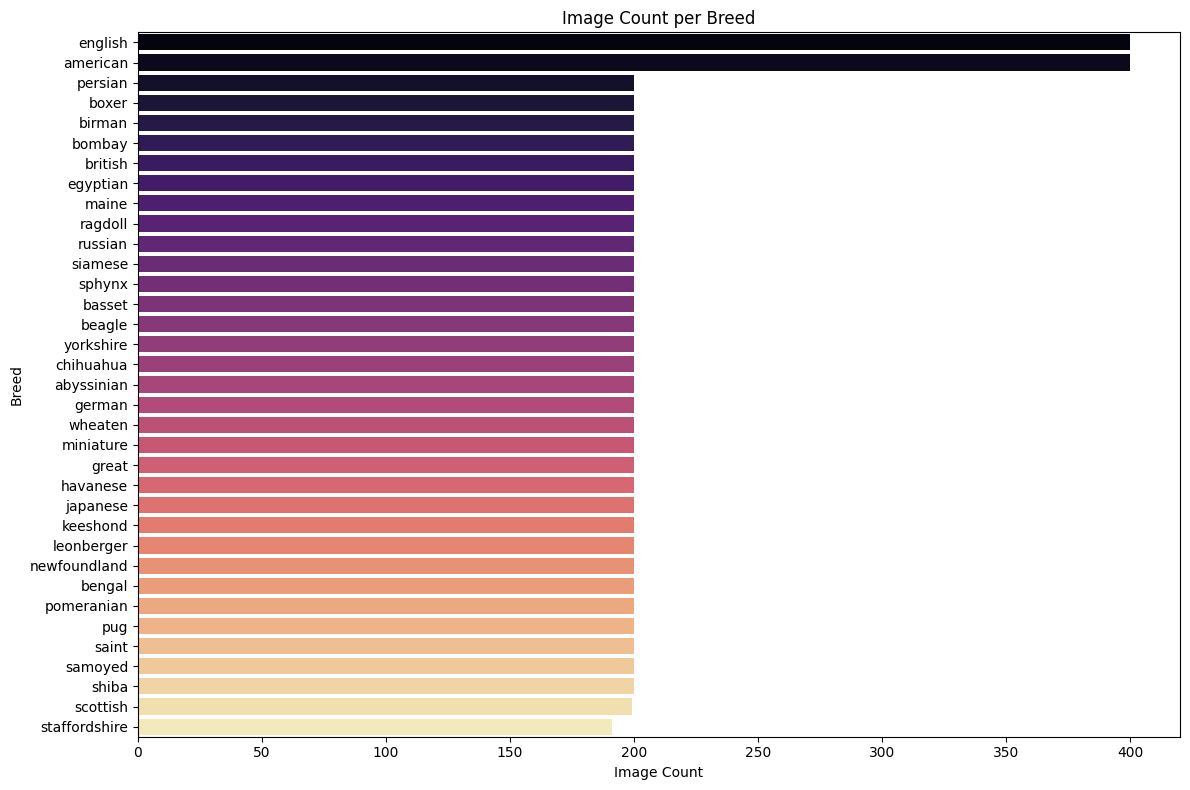

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(y='Breed', x='Count', data=df_breeds.sort_values(by='Count', ascending=False), palette='magma')
plt.title("Image Count per Breed")
plt.xlabel("Image Count")
plt.ylabel("Breed")
plt.tight_layout()
plt.show()


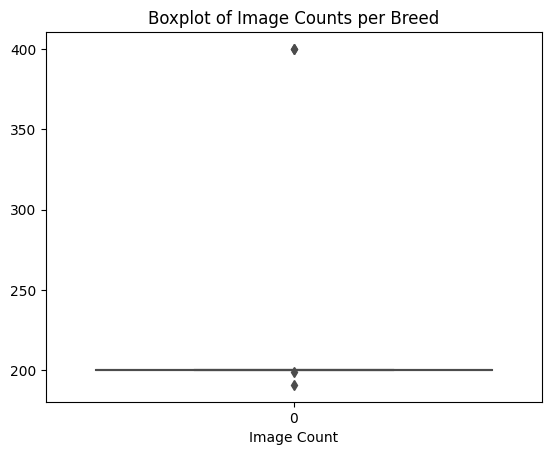

In [ ]:
sns.boxplot(data=df_breeds['Count'], color='orange')
plt.title("Boxplot of Image Counts per Breed")
plt.xlabel("Image Count")
plt.show()


In [ ]:

labels = [os.path.basename(p).split("_")[0].lower() for p in image_paths]
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])


X_train, X_val, y_train, y_val, m_train, m_val = train_test_split(
    image_paths, encoded_labels, mask_paths, test_size=0.2, random_state=42)

train_dataset = OxfordPetsDataset(X_train, m_train, y_train, transform)
val_dataset = OxfordPetsDataset(X_val, m_val, y_val, transform)


In [ ]:

class ClassificationOnlyModel(nn.Module):
    def __init__(self, num_classes):
        super(ClassificationOnlyModel, self).__init__()
        backbone = models.resnet34(pretrained=True)
        self.encoder = nn.Sequential(*list(backbone.children())[:-2])

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.encoder(x)
        class_out = self.classifier(features)
        return class_out



num_classes = 37

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


model = ClassificationOnlyModel(num_classes=num_classes).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses, val_accuracies, train_accuracies = [], [], []



In [ ]:
train_losses = []
train_accuracies = []
val_accuracies = []
val_losses = []


for epoch in range(20):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for imgs, masks, labels in train_loader:
        imgs, labels = imgs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    correct, total = 0, 0
    val_running_loss = 0
    with torch.no_grad():
        for imgs, masks, labels in val_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss = val_running_loss / len(val_loader)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f},Val Loss: {val_loss:.4f},, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1, Train Loss: 1.5012,Val Loss: 0.4993,, Train Acc: 0.6348, Val Acc: 0.8667
Epoch 2, Train Loss: 0.4748,Val Loss: 0.3549,, Train Acc: 0.8714, Val Acc: 0.8884
Epoch 3, Train Loss: 0.2727,Val Loss: 0.3622,, Train Acc: 0.9274, Val Acc: 0.8850
Epoch 4, Train Loss: 0.1865,Val Loss: 0.4672,, Train Acc: 0.9499, Val Acc: 0.8654
Epoch 5, Train Loss: 0.1897,Val Loss: 0.4000,, Train Acc: 0.9472, Val Acc: 0.8911
Epoch 6, Train Loss: 0.1444,Val Loss: 0.4403,, Train Acc: 0.9609, Val Acc: 0.8816
Epoch 7, Train Loss: 0.1078,Val Loss: 0.4466,, Train Acc: 0.9697, Val Acc: 0.8762
Epoch 8, Train Loss: 0.1047,Val Loss: 0.4971,, Train Acc: 0.9711, Val Acc: 0.8755
Epoch 9, Train Loss: 0.0965,Val Loss: 0.4837,, Train Acc: 0.9743, Val Acc: 0.8742
Epoch 10, Train Loss: 0.0876,Val Loss: 0.4402,, Train Acc: 0.9762, Val Acc: 0.8857
Epoch 11, Train Loss: 0.0845,Val Loss: 0.6142,, Train Acc: 0.9817, Val Acc: 0.8525
Epoch 12, Train Loss: 0.0762,Val Loss: 0.5786,, Train Acc: 0.9782, Val Acc: 0.8599
Epoch 13, Tra

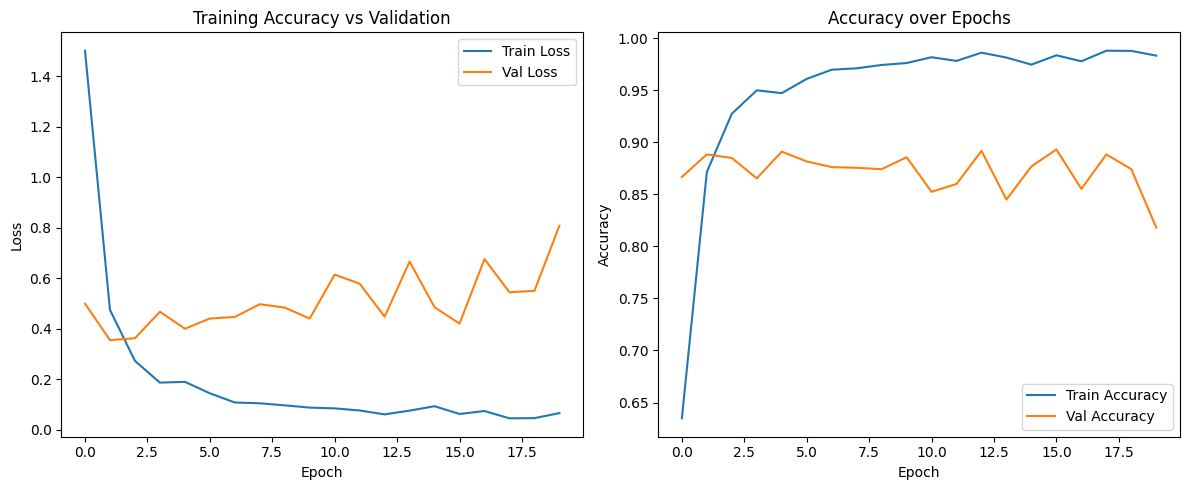

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Accuracy vs Validation')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
class MultiTaskPetModel(nn.Module):
    def __init__(self, num_classes):
        super(MultiTaskPetModel, self).__init__()
        self.backbone = models.resnet34(pretrained=True)

        self.encoder = nn.Sequential(*list(self.backbone.children())[:-2])

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        self.segmentation_head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.encoder(x)

        class_out = self.classifier(features)


        seg_out = F.interpolate(self.segmentation_head(features), size=x.shape[2:], mode='bilinear', align_corners=False)

        return class_out, seg_out

In [ ]:

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

model = MultiTaskPetModel(num_classes=len(label_encoder.classes_)).cuda()

criterion_cls = nn.CrossEntropyLoss()
criterion_seg = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(model, loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, masks, labels in loader:
        imgs, masks, labels = imgs.cuda(), masks.cuda(), labels.cuda()
        optimizer.zero_grad()

        cls_out, seg_out = model(imgs)
        loss_cls = criterion_cls(cls_out, labels)
        loss_seg = criterion_seg(seg_out, masks)
        loss = loss_cls + loss_seg

        loss.backward()
        optimizer.step()
        running_loss += loss.item()


        preds = torch.argmax(cls_out, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / len(loader)
    acc = correct / total
    return avg_loss, acc


def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    val_running_loss = 0

    with torch.no_grad():
        for imgs, masks, labels in loader:
            imgs, masks, labels = imgs.cuda(), masks.cuda(), labels.cuda()
            cls_out, seg_out = model(imgs)

            loss_cls = criterion_cls(cls_out, labels)
            loss_seg = criterion_seg(seg_out, masks)
            loss = loss_cls + loss_seg

            val_running_loss += loss.item()

            preds = torch.argmax(cls_out, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss = val_running_loss / len(loader)
    return val_loss, val_acc

train_losses = []
train_accuracies = []
val_accuracies = []
val_losses = []

for epoch in range(20):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1, Train Loss: 1.5456, Train Acc: 0.6421, Val Loss: 0.4691, Val Acc: 0.8823
Epoch 2, Train Loss: 0.5278, Train Acc: 0.8747, Val Loss: 0.3940, Val Acc: 0.8870
Epoch 3, Train Loss: 0.3376, Train Acc: 0.9229, Val Loss: 0.4813, Val Acc: 0.8687
Epoch 4, Train Loss: 0.2359, Train Acc: 0.9513, Val Loss: 0.6140, Val Acc: 0.8417
Epoch 5, Train Loss: 0.1995, Train Acc: 0.9586, Val Loss: 0.4914, Val Acc: 0.8694
Epoch 6, Train Loss: 0.1571, Train Acc: 0.9704, Val Loss: 0.4482, Val Acc: 0.8938
Epoch 7, Train Loss: 0.1513, Train Acc: 0.9714, Val Loss: 0.4933, Val Acc: 0.8728
Epoch 8, Train Loss: 0.1648, Train Acc: 0.9682, Val Loss: 0.5111, Val Acc: 0.8850
Epoch 9, Train Loss: 0.1406, Train Acc: 0.9745, Val Loss: 0.4179, Val Acc: 0.8951
Epoch 10, Train Loss: 0.1410, Train Acc: 0.9756, Val Loss: 0.5430, Val Acc: 0.8687
Epoch 11, Train Loss: 0.1372, Train Acc: 0.9743, Val Loss: 0.5178, Val Acc: 0.8728
Epoch 12, Train Loss: 0.0923, Train Acc: 0.9888, Val Loss: 0.4439, Val Acc: 0.8985
Epoch 13, Tra

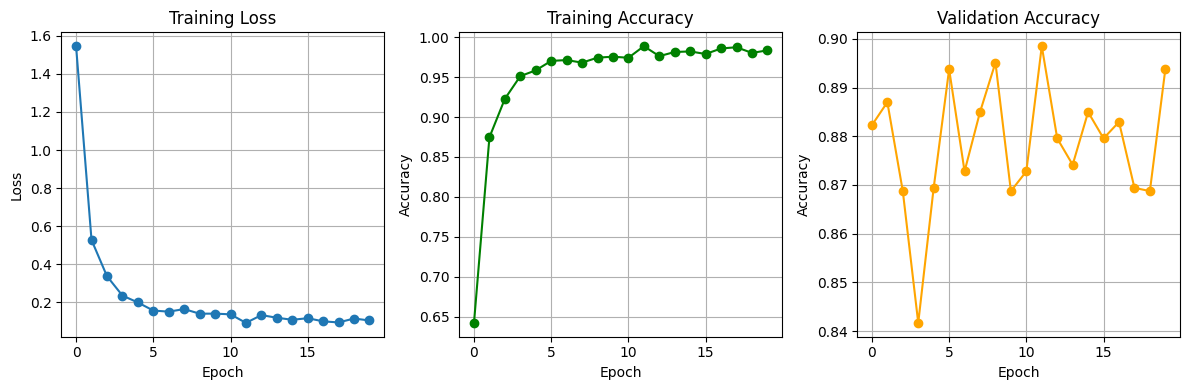

In [ ]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Acc', color='green', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)


plt.subplot(1, 3, 3)
plt.plot(val_accuracies, label='Val Acc', color='orange', marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


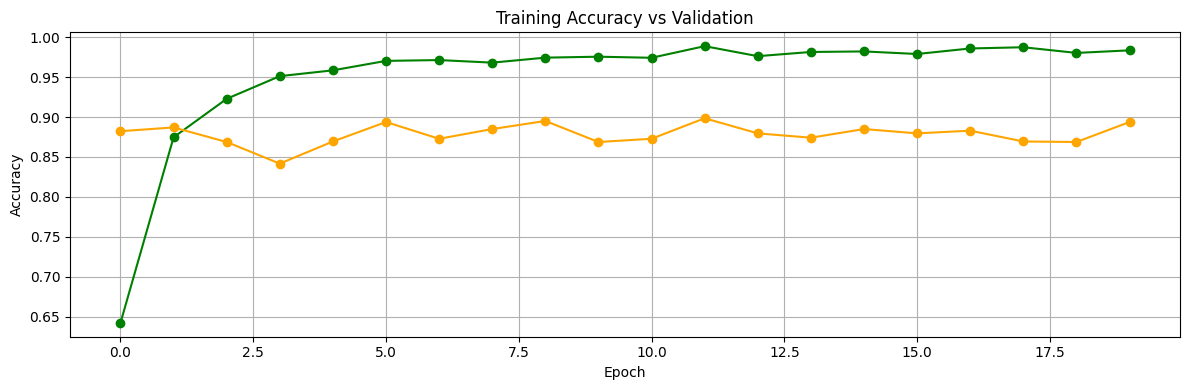

In [ ]:

plt.figure(figsize=(12, 4))

plt.plot(train_accuracies, label='Train Acc', color='green', marker='o')
plt.plot(val_accuracies, label='Val Acc', color='orange', marker='o')

plt.title('Training Accuracy vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)



plt.tight_layout()
plt.show()


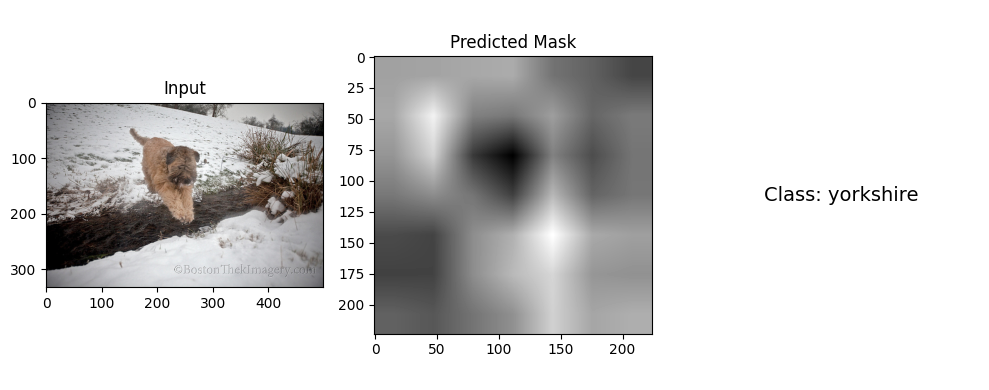

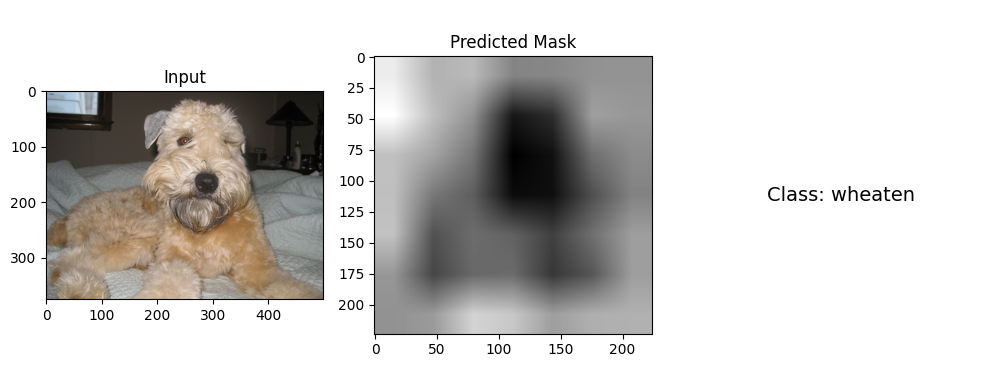

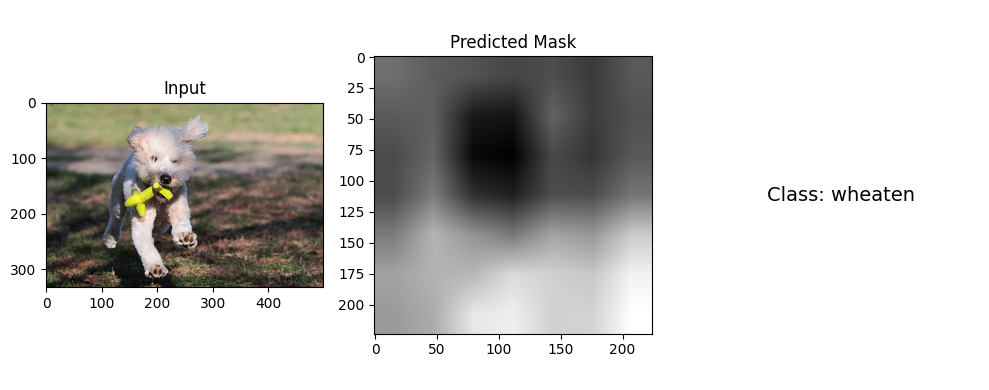

In [ ]:
model.eval()
test_paths = [
    "./images/wheaten_terrier_32.jpg",
    "./images/wheaten_terrier_33.jpg",
    "./images/wheaten_terrier_34.jpg"
]

for path in test_paths:
    img = Image.open(path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).cuda()

    with torch.no_grad():
        cls_out, seg_out = model(input_tensor)
        pred_class = torch.argmax(cls_out, dim=1).item()
        pred_mask = seg_out.squeeze().cpu()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")

    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, f"Class: {label_encoder.inverse_transform([pred_class])[0]}",
             ha='center', va='center', fontsize=14)
    plt.axis('off')

    plt.tight_layout()
    plt.show()
